In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import lightgbm as lgb
import optuna

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from functools import reduce
from tqdm import tqdm

## Task #1: Basic manipulation and descriptive statistics
### Import the Data_PCLab4_Stock_Price.csv data and the Data_PCLab4_Stock_Volume.csv

In [2]:
price_df = pd.read_csv('data/Data_PCLab4_Stock_Price.csv')
volume_df = pd.read_csv('data/Data_PCLab4_Stock_Volume.csv')

In [3]:
price_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,60.198570,75.510002,30.120001,12.13,175.929993,180.550003,28.250000,313.644379,1295.500000
1,2012-01-13,59.972858,74.599998,30.070000,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966
2,2012-01-17,60.671429,75.239998,30.250000,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044
3,2012-01-18,61.301430,75.059998,30.330000,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039
4,2012-01-19,61.107143,75.559998,30.420000,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000


In [4]:
volume_df.head()

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,53146800,3934500,26511100,17891100,5385800,6881000,729300,3764400,4019890000
1,2012-01-13,56505400,4641100,22096800,16621800,4753500,5279200,5500400,4631800,3692370000
2,2012-01-17,60724300,3700100,23500200,15480800,5644500,6003400,4651600,3832800,4010490000
3,2012-01-18,69197800,4189500,22015000,18387600,7473500,4600600,1260200,5544000,4096160000
4,2012-01-19,65434600,5397300,25524000,14022900,7096000,8567200,1246300,12657800,4465890000


### Describe the sample:
<ul>
  <li>What is the average trading volume for Apple stock?</li>
  <li>What is the maximum trading volume for S&P500?</li>
  <li>Which security is traded the most? Comment on your answer</li>
</ul>


In [5]:
volume_df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
count,2159.00,2159.00,2159.00,2159.00,2159.00,2159.00,2159.00,2159.00,2159.00
mean,58203317.42,6419915.93,28321313.57,9845581.70,4102672.90,4453089.53,7001302.27,2498238.26,3680732468.74
std,45681411.90,9711873.15,14289105.90,7295752.64,2290722.34,2462811.45,5781207.84,1928407.25,862271696.84
min,11362000.00,788900.00,6862400.00,950700.00,881300.00,1193000.00,364900.00,7900.00,1248960000.00
25%,27699300.00,3031850.00,20021500.00,5796450.00,2675700.00,3111250.00,3433450.00,1325400.00,3211890000.00
50%,42094200.00,3991000.00,24859300.00,7899800.00,3494800.00,3825000.00,5581100.00,1813900.00,3526890000.00
75%,71824800.00,5325900.00,32105650.00,11040550.00,4768150.00,4937300.00,8619550.00,3245350.00,3933290000.00
max,376530000.00,103212800.00,195082700.00,90098200.00,23856100.00,30490200.00,60938800.00,24977900.00,9044690000.00


<ul>
  <li>The average trading volume for Apple is 58203317.42.</li>
  <li>The maximum trading volume for S&P 500 is 9044690000.</li>
  <li>The most traded security is Apple. It is the largest company in the world by market capitalization, which makes it perceived as a stable investment by both institutional and retail investors. For the same reason, it is the biggest constituent of stock indices like the S&P 500, Dow Jones Industrial Average, and NASDAQ-100. Many exchange-traded funds track these indices, resulting in consistent buying and selling of AAPL shares to mirror index movements.</li>
</ul>

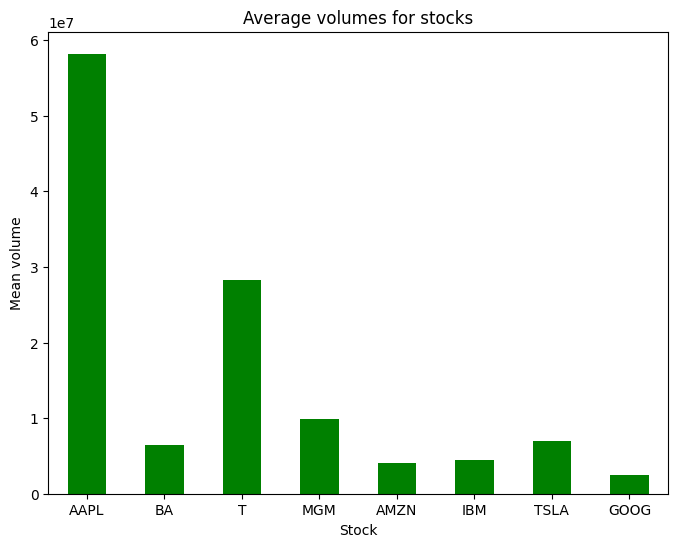

In [6]:
# Plot the average volumes for securities. We can see that the most traded one is Apple
volume_df.iloc[:, :-1].describe().loc['mean'].plot(kind='bar', color='g', figsize=(8,6))
plt.title('Average volumes for stocks')
plt.ylabel('Mean volume')
plt.xlabel('Stock')
plt.xticks(rotation=0)
plt.show()

### Plot the time series of volumes for all stocks (raw and normalized)

In [7]:
def plot1(dataframe): 
    """
    Create the time series plot for the entire dataframe.
    """
    df = dataframe.copy()
    df.set_index(df.columns[0], inplace=True)
    df.index = pd.to_datetime(df.index)
    df.plot(figsize=(10, 6))
    plt.xlabel('Date')
    plt.grid(True)
    plt.show()

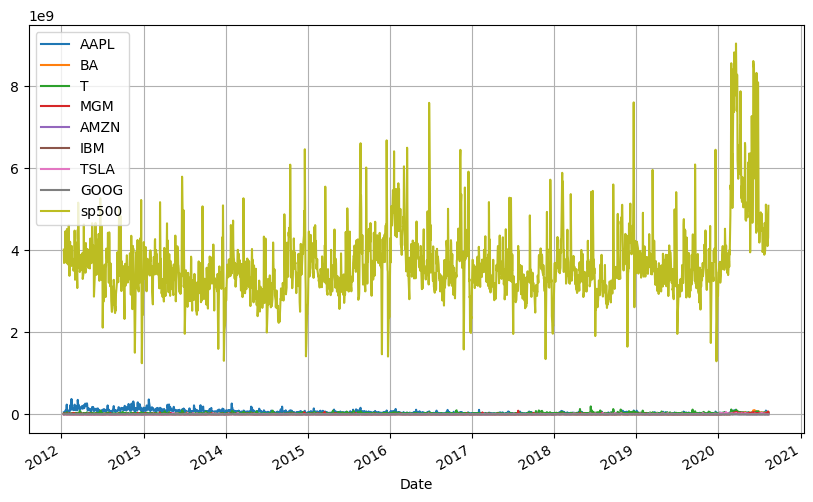

In [8]:
plot1(volume_df) # plot for all stocks (raw)

The trading volume for the S&P 500 index is significantly higher than that of individual securities, which makes the plot unclear.

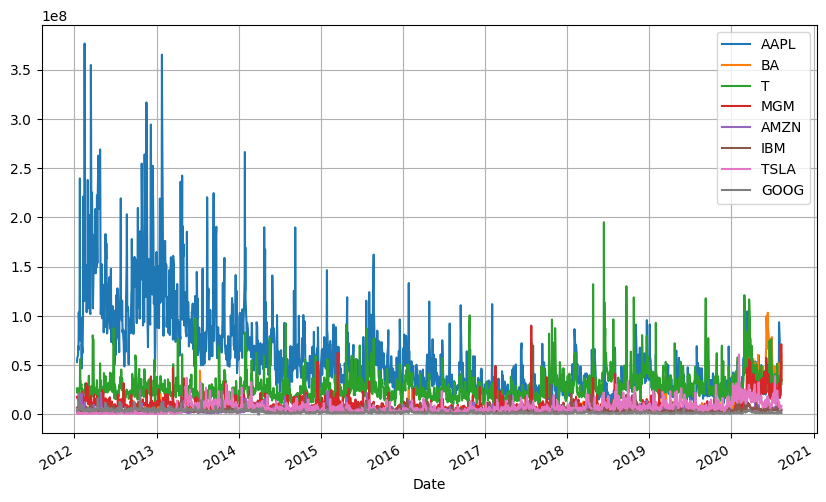

In [9]:
plot1(volume_df.iloc[:,:-1]) # plot for the securities (without sp500)

Let's also plot the volume distribution!

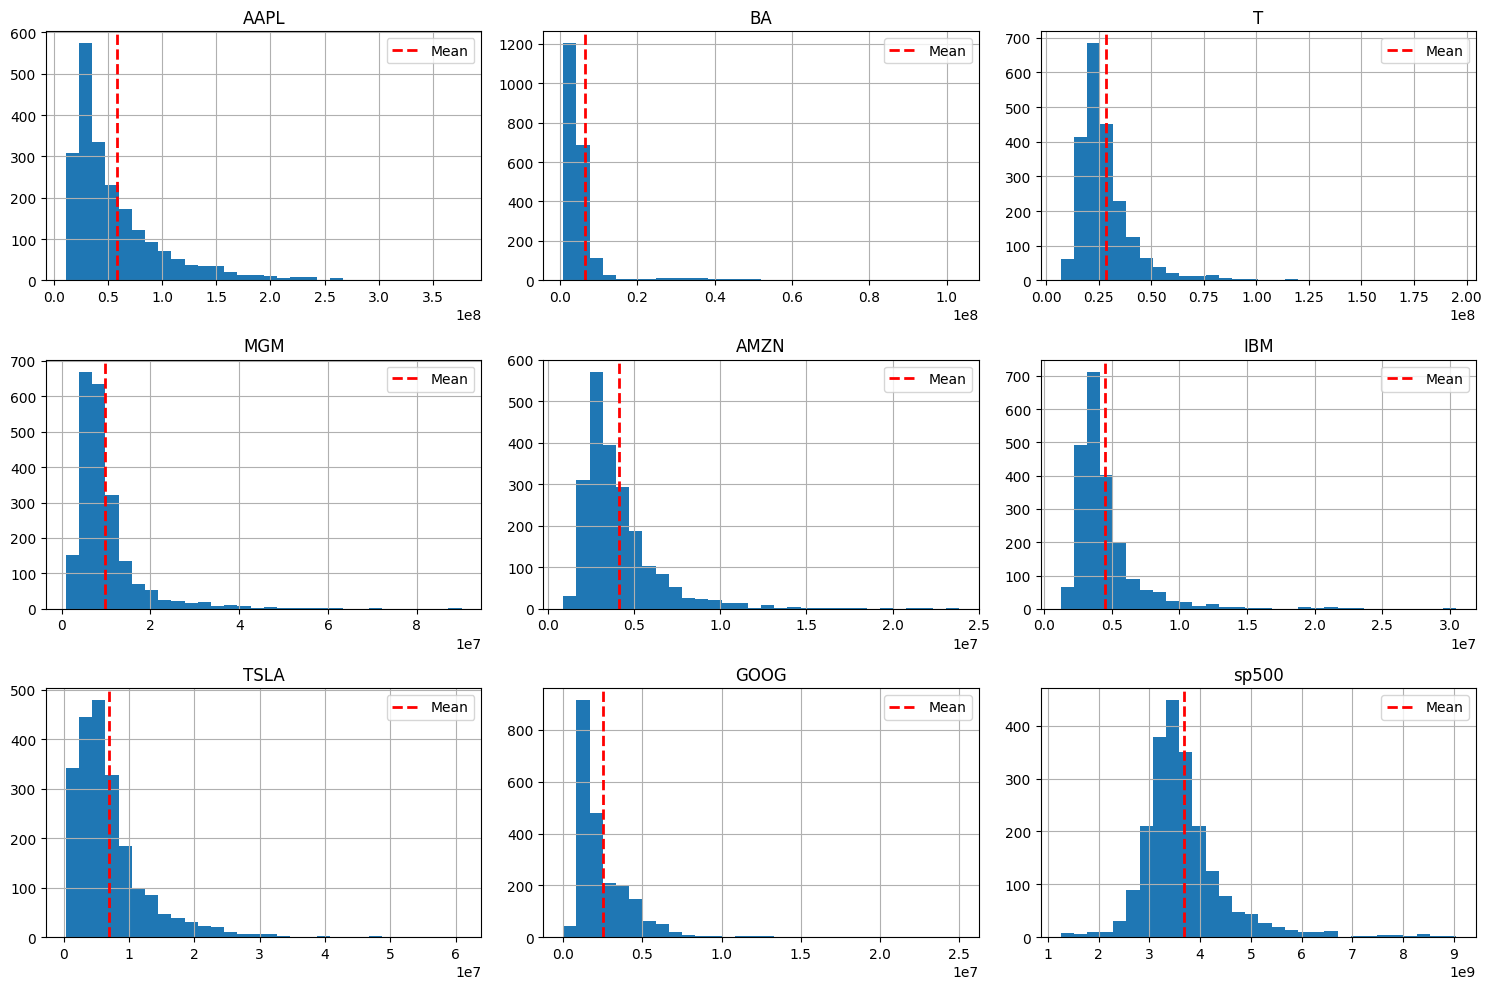

In [10]:
ax = volume_df.iloc[:, 1:].hist(bins=30, figsize=(15, 10), layout=(3, 3)) # histograms for the volumes change
plt.tight_layout()
for i, col in enumerate(volume_df.columns[1:]):
    mean = volume_df[col].mean()
    ax.flatten()[i].axvline(mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
    ax.flatten()[i].legend()
plt.show()

All the distributions are heavily skewed to the right. This suggests that extremely large trading volumes are rarer than extremely small ones. We can also see that the distribution of trading volume for the S&P 500 is much broader and higher overall which intuitively makes sense since it reflects the aggregate activity of a large number of companies.

Now we normalize the values to check how they changed over time.

In [11]:
def norm_data(df):
    df_copy = df.copy()
    df_copy.iloc[:, 1:] = pd.DataFrame(df_copy.iloc[:, 1:].div(df_copy.iloc[0, 1:], axis=1))
    return df_copy

In [12]:
norm_data(volume_df)

,Date,AAPL,BA,T,MGM,AMZN,IBM,TSLA,GOOG,sp500
0,2012-01-12,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2012-01-13,1.063195,1.179591,0.833492,0.929054,0.882599,0.767214,7.542027,1.230422,0.918525
2,2012-01-17,1.142577,0.940424,0.886429,0.865279,1.048034,0.87246,6.378171,1.01817,0.997662
3,2012-01-18,1.302013,1.064811,0.830407,1.027751,1.38763,0.668595,1.727958,1.472745,1.018973
4,2012-01-19,1.231205,1.371788,0.962767,0.783792,1.317539,1.245052,1.708899,3.362501,1.110948
...,...,...,...,...,...,...,...,...,...,...
2154,2020-08-05,0.573845,11.831491,0.867248,1.057185,0.729697,0.534137,6.825723,0.525847,1.177201
2155,2020-08-06,0.952215,8.367416,0.826397,2.004779,0.731665,0.496599,8.216509,0.530071,1.061594
2156,2020-08-07,0.930504,4.905731,1.146633,1.930027,0.729622,0.530591,12.180858,0.418818,1.021137
2157,2020-08-10,0.999136,9.113661,1.339605,3.980733,0.588083,0.576704,10.314411,0.342498,1.074301


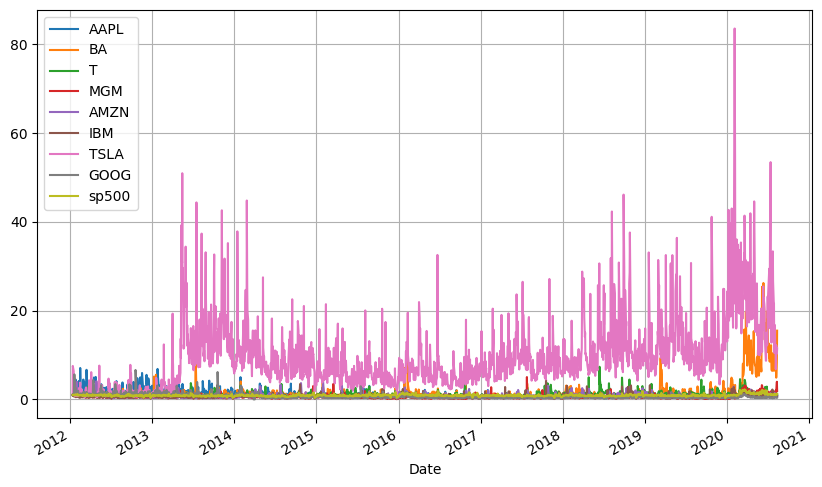

In [13]:
plot1(norm_data(volume_df))

The first observation is that the volume of Tesla stocks has increased significantly over the years, with a notable boom beginning in 2013.

In contrast, the volume of S&P 500 stocks remained relatively stable throughout the period, except for a noticeable spike during the COVID-19 pandemic. A significant increase in Boeing's stock volume can also be observed during this time.

### Is there a correlation between change in prices (returns) and change in volumes?

In [14]:
def daily_change(data):
    newdata = pd.DataFrame()
    newdata['Date'] = data['Date'][1:].reset_index(drop=True)
    
    for column in data.columns[1:]:
        newdata[column] = data[column].pct_change().dropna().reset_index(drop=True) * 100
    
    return newdata

In [15]:
price_change = daily_change(price_df) # dataframe with daily returns

In [16]:
volume_change = daily_change(volume_df) # dataframe with daily change of volume

In [17]:
correlations = {}
abs_correlations = {}

for stock in price_change.columns.difference(['Date']):
    # Regular correlation
    correlations[stock] = price_change[stock].corr(volume_change[stock])
    # Correlation between absolute price change and volume change
    abs_correlations[stock] = price_change[stock].abs().corr(volume_change[stock])

correlation_df = pd.DataFrame({
    'Stock': correlations.keys(),
    'Correlation': correlations.values(),
    'Abs_Correlation': abs_correlations.values()
})

correlation_df

,Stock,Correlation,Abs_Correlation
0,AAPL,-0.114204,0.339589
1,AMZN,0.070281,0.403379
2,BA,-0.071670,0.289918
3,GOOG,-0.024028,0.140329
4,IBM,-0.081546,0.351874
5,MGM,0.025558,0.267086
6,T,-0.139598,0.310832
7,TSLA,0.045621,0.517331
8,sp500,-0.102456,0.131090


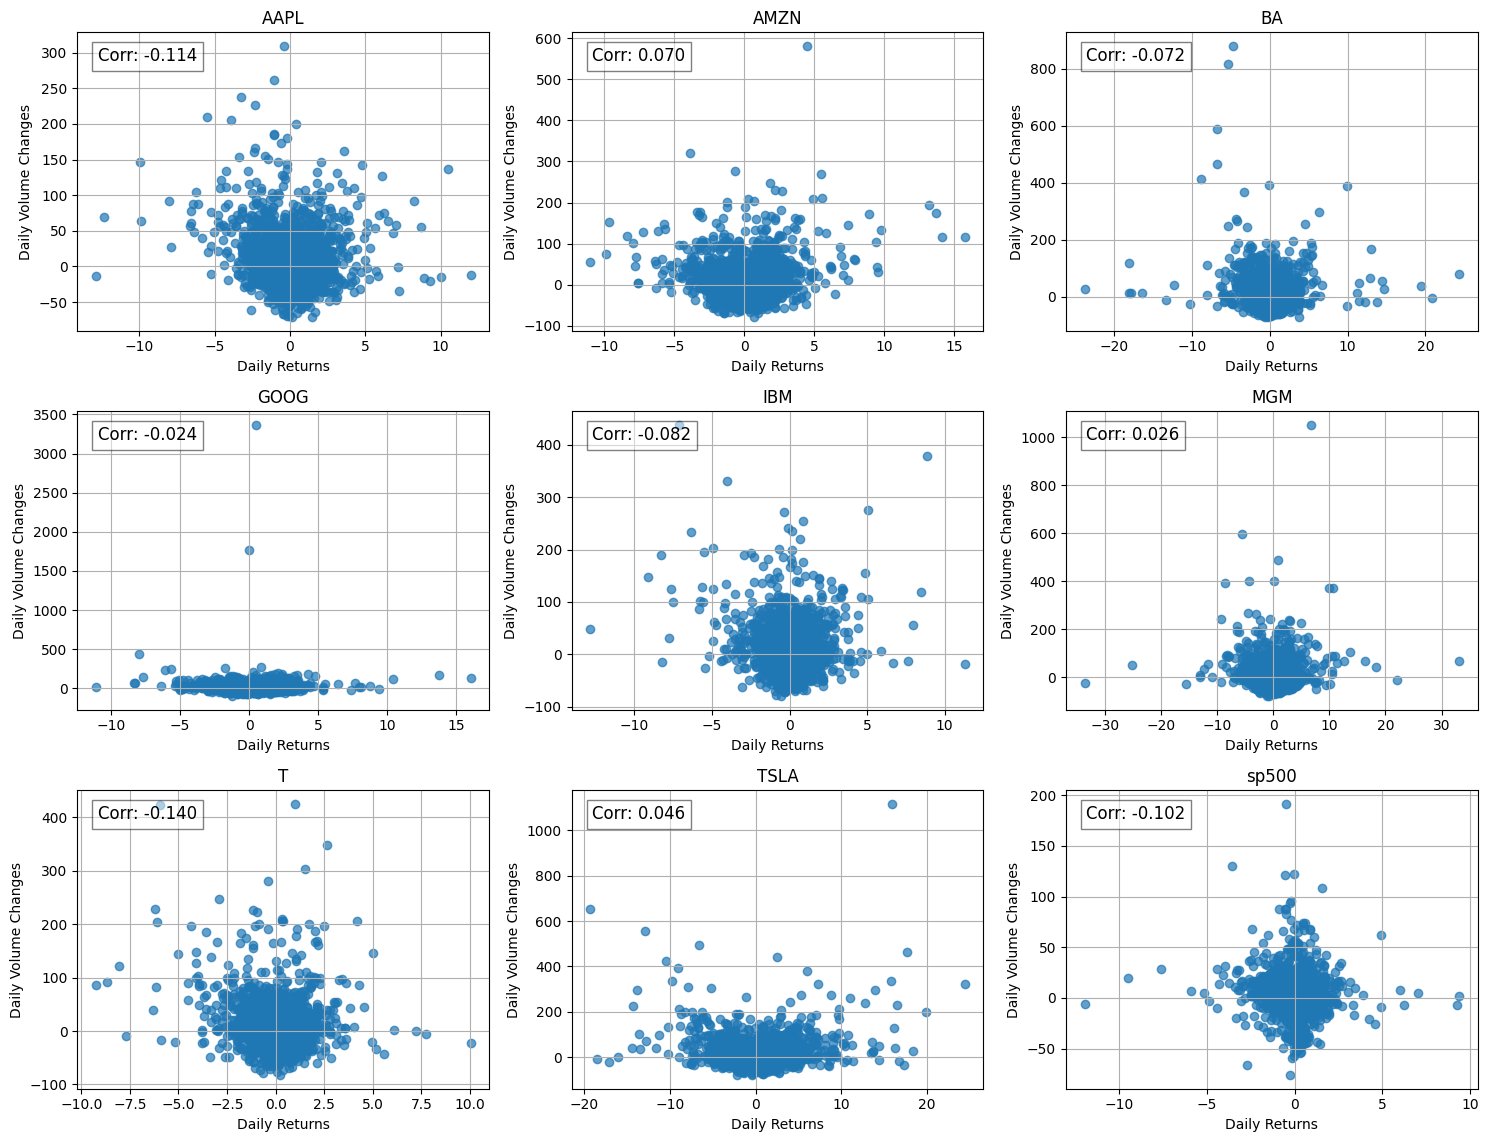

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

axes = axes.flatten()

for i, stock in enumerate(price_change.columns.difference(['Date'])):
    axes[i].scatter(price_change[stock], volume_change[stock], alpha=0.7)
    axes[i].set_title(stock)
    axes[i].set_xlabel('Daily Returns')
    axes[i].set_ylabel('Daily Volume Changes')
    corr_value = correlations[stock]
    axes[i].text(0.05, 0.95, f'Corr: {corr_value:.3f}', transform=axes[i].transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


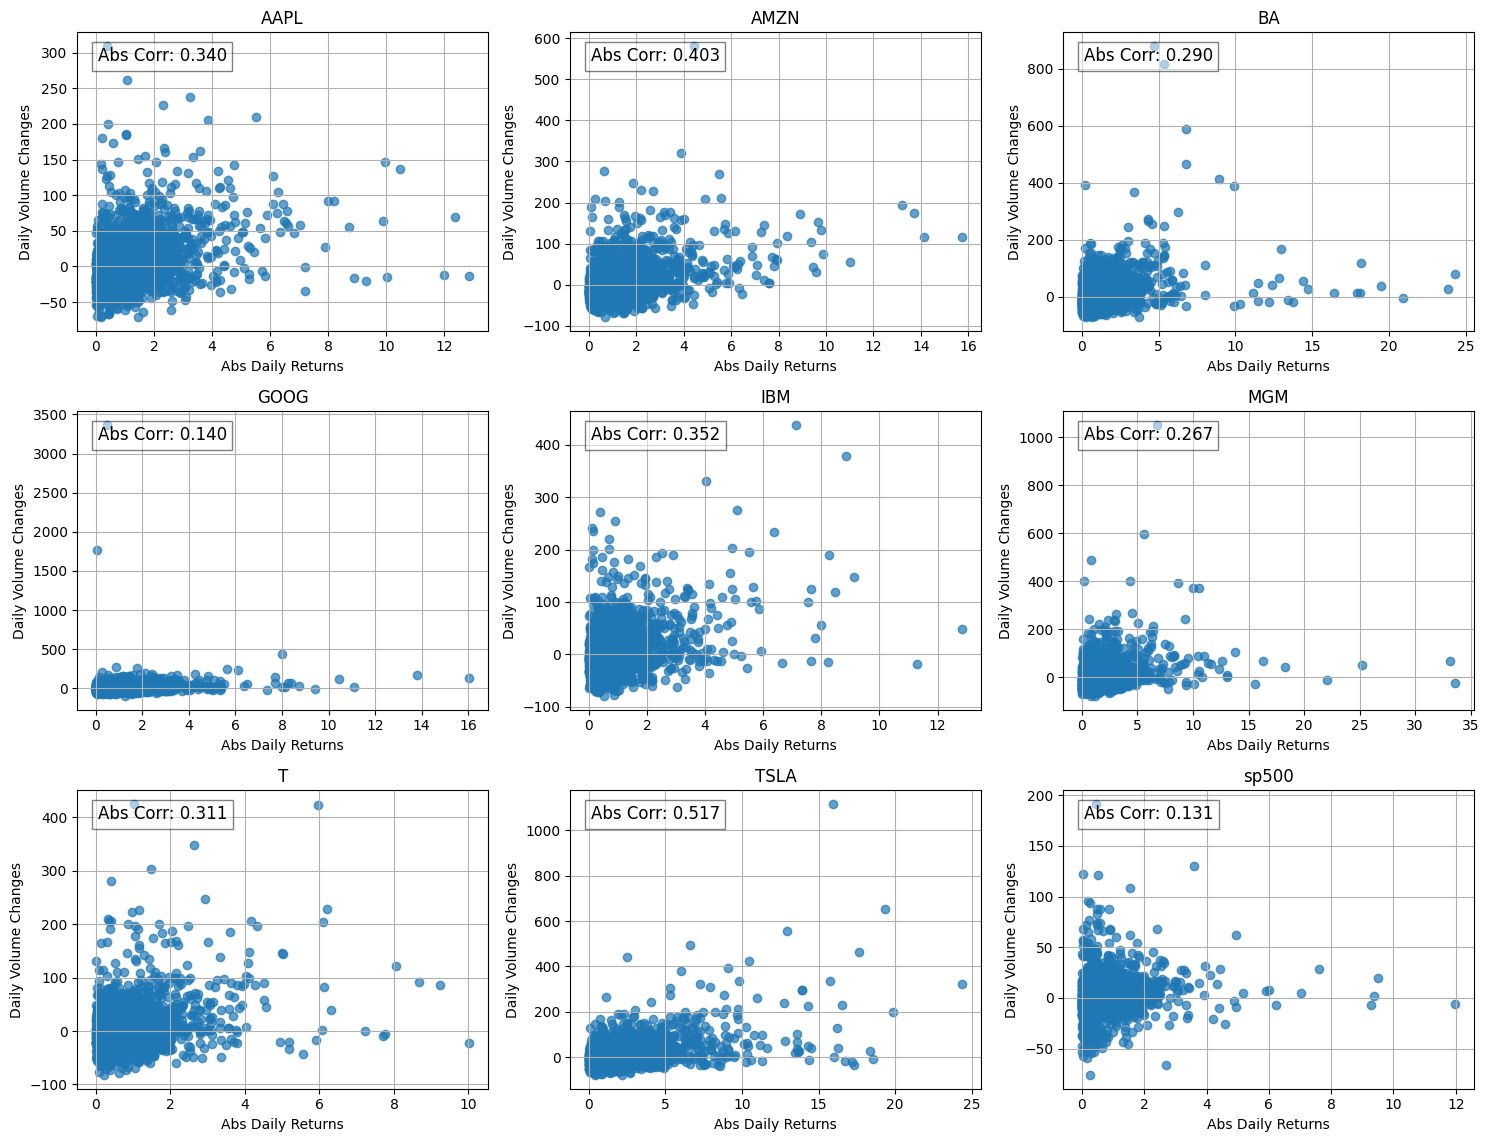

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

axes = axes.flatten()

for i, stock in enumerate(price_change.columns.difference(['Date'])):
    axes[i].scatter(price_change[stock].abs(), volume_change[stock], alpha=0.7)
    axes[i].set_title(stock)
    axes[i].set_xlabel('Abs Daily Returns')
    axes[i].set_ylabel('Daily Volume Changes')
    
    abs_corr_value = abs_correlations[stock]
    axes[i].text(0.05, 0.95, f'Abs Corr: {abs_corr_value:.3f}', transform=axes[i].transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    
    axes[i].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


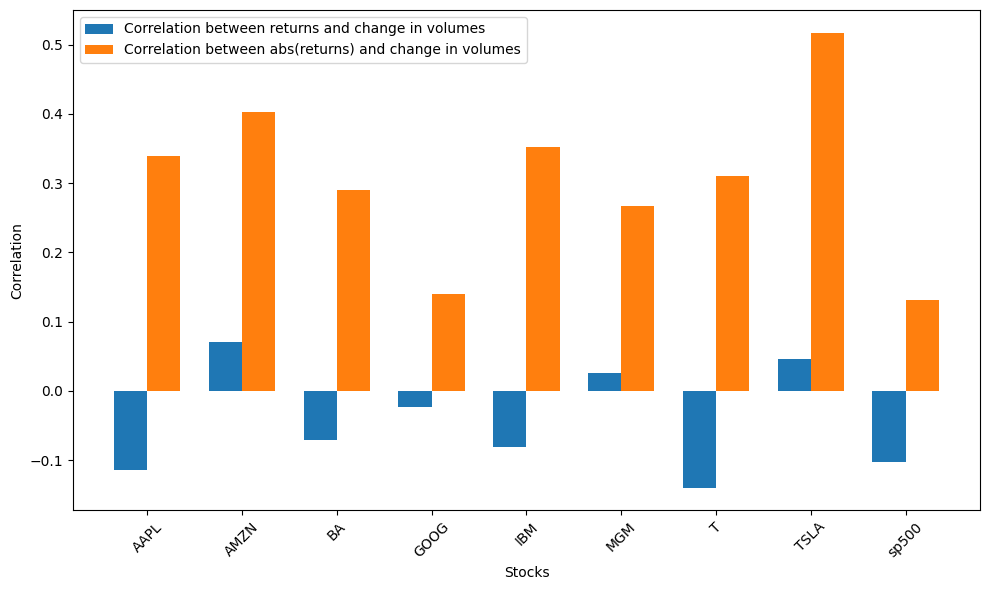

In [20]:
# Data preparation
stocks = correlation_df['Stock']
correlation_values = correlation_df['Correlation']
abs_correlation_values = correlation_df['Abs_Correlation']

# Setting up the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Width of the bars
bar_width = 0.35
index = np.arange(len(stocks))

# Plotting both correlation and absolute correlation side by side
bars1 = ax.bar(index, correlation_values, bar_width, label='Correlation between returns and change in volumes')
bars2 = ax.bar(index + bar_width, abs_correlation_values, bar_width, label='Correlation between abs(returns) and change in volumes')

# Labels and title
ax.set_xlabel('Stocks')
ax.set_ylabel('Correlation')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(stocks, rotation=45)

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

As we can see, there is little to no correlation between price changes and volume for any of the stocks. However, if we compare the absolute price change instead of the regular price change, we can notice some relationships. Specifically, higher volumes can lead to greater absolute changes in the stock market. This makes sense because increased trading activity reflects strong market sentiment that can be either positive or negative. Thus, when large quantities of a stock are bought or sold, it can create upward or downward pressure on the stock's price.

## Task #2: Train and Test samples + Ridge regression

In [21]:
df = pd.merge(price_df, volume_df, on='Date', suffixes=('_price', '_volume'))

In [22]:
lagged_columns = [col for col in df.columns if col != 'Date']

for col in lagged_columns:
    df[f'{col}_lag'] = df[col].shift(1)

In [23]:
df.dropna(inplace=True)
df.head()

,Date,AAPL_price,BA_price,T_price,MGM_price,AMZN_price,IBM_price,TSLA_price,GOOG_price,sp500_price,...,sp500_price_lag,AAPL_volume_lag,BA_volume_lag,T_volume_lag,MGM_volume_lag,AMZN_volume_lag,IBM_volume_lag,TSLA_volume_lag,GOOG_volume_lag,sp500_volume_lag
1,2012-01-13,59.972858,74.599998,30.07,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966,...,1295.500000,53146800.0,3934500.0,26511100.0,17891100.0,5385800.0,6881000.0,729300.0,3764400.0,4.019890e+09
2,2012-01-17,60.671429,75.239998,30.25,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044,...,1289.089966,56505400.0,4641100.0,22096800.0,16621800.0,4753500.0,5279200.0,5500400.0,4631800.0,3.692370e+09
3,2012-01-18,61.301430,75.059998,30.33,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039,...,1293.670044,60724300.0,3700100.0,23500200.0,15480800.0,5644500.0,6003400.0,4651600.0,3832800.0,4.010490e+09
4,2012-01-19,61.107143,75.559998,30.42,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000,...,1308.040039,69197800.0,4189500.0,22015000.0,18387600.0,7473500.0,4600600.0,1260200.0,5544000.0,4.096160e+09
5,2012-01-20,60.042858,75.519997,30.51,12.64,190.929993,188.520004,26.600000,291.900879,1315.380005,...,1314.500000,65434600.0,5397300.0,25524000.0,14022900.0,7096000.0,8567200.0,1246300.0,12657800.0,4.465890e+09


In [24]:
train_size = int(df.shape[0]*0.75)
train = df[:train_size]
test = df[train_size:]

In [25]:
train.head()

,Date,AAPL_price,BA_price,T_price,MGM_price,AMZN_price,IBM_price,TSLA_price,GOOG_price,sp500_price,...,sp500_price_lag,AAPL_volume_lag,BA_volume_lag,T_volume_lag,MGM_volume_lag,AMZN_volume_lag,IBM_volume_lag,TSLA_volume_lag,GOOG_volume_lag,sp500_volume_lag
1,2012-01-13,59.972858,74.599998,30.07,12.35,178.419998,179.160004,22.790001,311.328064,1289.089966,...,1295.500000,53146800.0,3934500.0,26511100.0,17891100.0,5385800.0,6881000.0,729300.0,3764400.0,4.019890e+09
2,2012-01-17,60.671429,75.239998,30.25,12.25,181.660004,180.000000,26.600000,313.116364,1293.670044,...,1289.089966,56505400.0,4641100.0,22096800.0,16621800.0,4753500.0,5279200.0,5500400.0,4631800.0,3.692370e+09
3,2012-01-18,61.301430,75.059998,30.33,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039,...,1293.670044,60724300.0,3700100.0,23500200.0,15480800.0,5644500.0,6003400.0,4651600.0,3832800.0,4.010490e+09
4,2012-01-19,61.107143,75.559998,30.42,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000,...,1308.040039,69197800.0,4189500.0,22015000.0,18387600.0,7473500.0,4600600.0,1260200.0,5544000.0,4.096160e+09
5,2012-01-20,60.042858,75.519997,30.51,12.64,190.929993,188.520004,26.600000,291.900879,1315.380005,...,1314.500000,65434600.0,5397300.0,25524000.0,14022900.0,7096000.0,8567200.0,1246300.0,12657800.0,4.465890e+09


In [26]:
cols_to_scale = train.columns.difference(['Date'])

# Fit the scaler only on the training set to avoid data leakage
scaler = MinMaxScaler()
train.loc[:, cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
test.loc[:, cols_to_scale] = scaler.transform(test[cols_to_scale])

# Store the scaling parameters for each column
data_min = scaler.data_min_
data_max = scaler.data_max_
data_min_dict = dict(zip(cols_to_scale, data_min))
data_max_dict = dict(zip(cols_to_scale, data_max))

In [27]:
targets = ['AAPL_price', 'BA_price', 'T_price', 'MGM_price', 'AMZN_price', 'IBM_price', 'TSLA_price', 'GOOG_price']

# Include only lag features (exclude market data for now)
features = [col for col in train.columns if col.endswith('lag') and not col.startswith('sp500')] 

In [28]:
def prepare_pooled_data(data, features, targets):
    """
    Transform the data into a pooled format and create dummy variables for targets.
    """
    # Melt data into long format
    pooled = data.melt(
        id_vars=['Date'] + features,
        value_vars=targets,
        var_name='target',
        value_name='y_scaled'
    )
    
    # Create dummy variables for 'target', excluding the first to prevent multicollinearity
    dummies = pd.get_dummies(pooled['target'], drop_first=True).astype(int)
    # Rename the dummy variables from TICKER_price to TICKER for clarity
    dummies.columns = [col.split('_')[0] for col in dummies.columns]  

    # Combine features and dummy variables
    pooled = pd.concat([pooled, dummies], axis=1)
    dummy_cols = dummies.columns.tolist()
    return pooled, dummy_cols

train_pooled, dummy_cols = prepare_pooled_data(train, features, targets)
test_pooled, _ = prepare_pooled_data(test, features, targets)

print("Dummy variables:", dummy_cols)

Dummy variables: ['AMZN', 'BA', 'GOOG', 'IBM', 'MGM', 'TSLA', 'T']


In [29]:
test_pooled

,Date,AAPL_price_lag,BA_price_lag,T_price_lag,MGM_price_lag,AMZN_price_lag,IBM_price_lag,TSLA_price_lag,GOOG_price_lag,AAPL_volume_lag,...,GOOG_volume_lag,target,y_scaled,AMZN,BA,GOOG,IBM,MGM,TSLA,T
0,2018-06-20,0.940010,0.899974,0.225716,0.720289,1.007055,0.265952,0.910411,0.991330,0.060546,...,0.064602,AAPL_price,0.945872,0,0,0,0,0,0,0
1,2018-06-21,0.945872,0.905133,0.198463,0.741991,1.016939,0.252986,0.937108,0.993314,0.025072,...,0.065703,AAPL_price,0.938346,0,0,0,0,0,0,0
2,2018-06-22,0.938346,0.888604,0.170510,0.734068,1.004109,0.238897,0.896497,0.979741,0.038997,...,0.049267,AAPL_price,0.934438,0,0,0,0,0,0,0
3,2018-06-25,0.934438,0.892712,0.176799,0.725801,0.994709,0.239204,0.858176,0.977311,0.043074,...,0.052187,AAPL_price,0.914538,0,0,0,0,0,0,0
4,2018-06-26,0.914538,0.867376,0.178197,0.698243,0.960780,0.213782,0.856465,0.943133,0.055299,...,0.086079,AAPL_price,0.930892,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2020-08-05,2.770606,0.321471,0.059399,0.265932,1.914105,0.081572,4.042434,1.322201,0.087088,...,0.075915,GOOG_price,1.331829,0,0,1,0,0,0,0
4316,2020-08-06,2.782112,0.351735,0.048218,0.265932,1.956871,0.077591,4.036968,1.331829,0.052108,...,0.078959,GOOG_price,1.361349,0,0,1,0,0,0,0
4317,2020-08-07,2.893263,0.344900,0.047519,0.325870,1.969773,0.084431,4.049557,1.361349,0.107193,...,0.079596,GOOG_price,1.355098,0,0,1,0,0,0,0
4318,2020-08-10,2.812505,0.337737,0.060098,0.345505,1.932600,0.072588,3.947765,1.355098,0.104032,...,0.062823,GOOG_price,1.356892,0,0,1,0,0,0,0


In [30]:
def train_OLS(train_pooled, features, dummy_cols):
    """
    Train an OLS regression model using the pooled training data.
    """
    # Prepare training data
    X_train = train_pooled[features + dummy_cols]
    X_train = sm.add_constant(X_train)
    y_train = train_pooled['y_scaled']
    
    # Fit the model
    model = sm.OLS(y_train, X_train).fit()
    print(model.summary())
    return model

model = train_OLS(train_pooled, features, dummy_cols)

                            OLS Regression Results                            
Dep. Variable:               y_scaled   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     688.4
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        18:21:59   Log-Likelihood:                 4296.3
No. Observations:               12944   AIC:                            -8545.
Df Residuals:                   12920   BIC:                            -8365.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0215      0.014     

In [31]:
def inverse_transform(scaled_value, target, data_min_dict=data_min_dict, data_max_dict=data_max_dict):
    min_val = data_min_dict[target]
    max_val = data_max_dict[target]
    return scaled_value * (max_val - min_val) + min_val

def make_predictions(model, pooled_data, features, dummy_cols, model_type='OLS'):
    """
    Generate predictions, add lagged target prices, and inverse transform predictions to original scale.
    """
    # Prepare features for prediction
    X = pooled_data[features + dummy_cols]

    if model_type == 'OLS':
        X = sm.add_constant(X)
    
    # Make predictions
    if model_type in {'OLS', 'Ridge'}:
        pooled_data['y_pred_scaled'] = model.predict(X)
    elif model_type == 'NN':
        pooled_data['y_pred_scaled'] = model.predict(X).flatten()
    elif model_type == 'GBM':
        pooled_data['y_pred_scaled'] = model.predict(X, num_iteration=model.best_iteration)
    
    # Add lagged target price (still scaled)
    pooled_data['y_lag_scaled'] = pooled_data.apply(
        lambda row: row.get(row['target'].replace('_price', '_price_lag')), axis=1
    )
    
    # Inverse transform predictions and actual values
    pooled_data['y_pred'] = pooled_data.apply(lambda row: inverse_transform(row['y_pred_scaled'], row['target']), axis=1)
    pooled_data['y'] = pooled_data.apply(lambda row: inverse_transform(row['y_scaled'], row['target']), axis=1)
    pooled_data['y_lag'] = pooled_data.apply(lambda row: inverse_transform(row['y_lag_scaled'], row['target']), axis=1)
    
    return pooled_data


train_pooled = make_predictions(model, train_pooled, features, dummy_cols)
test_pooled = make_predictions(model, test_pooled, features, dummy_cols)

In [32]:
def calculate_returns(pooled_data):
    """
    Calculate actual and predicted returns based on target prices.
    """
    pooled_data['actual_return'] = (pooled_data['y'] - pooled_data['y_lag']) / pooled_data['y_lag']
    pooled_data['predicted_return'] = (pooled_data['y_pred'] - pooled_data['y_lag']) / pooled_data['y_lag']
    return pooled_data

test_pooled = calculate_returns(test_pooled)
test_pooled[['target', 'y_lag', 'y', 'y_pred', 'actual_return', 'predicted_return']].head()

,target,y_lag,y,y_pred,actual_return,predicted_return
0,AAPL_price,185.690002,186.500000,155.231099,0.004362,-0.164031
1,AAPL_price,186.500000,185.460007,155.717889,-0.005576,-0.165052
2,AAPL_price,185.460007,184.919998,153.220368,-0.002912,-0.173836
3,AAPL_price,184.919998,182.169998,152.319921,-0.014871,-0.176293
4,AAPL_price,182.169998,184.429993,149.493944,0.012406,-0.179371


In [33]:
def plot_results(train_pooled, test_pooled, train_dates, stock_ticker, NN=False):
    """
    Plot actual vs. predicted prices for a selected stock over time.
    """
    # Combine pooled data
    combined_pooled = pd.concat([train_pooled, test_pooled], ignore_index=True)
    combined_pooled['Date'] = pd.to_datetime(combined_pooled['Date'])
    
    # We will need that later
    if NN:
        combined_pooled['y_pred'] = pd.concat([pd.Series(model.predict(X_train).flatten()), pd.Series(model.predict(X_test).flatten())], ignore_index=True)

    # Filter for a selected stock data
    stock_data = combined_pooled[combined_pooled['target'] == f'{stock_ticker}_price'].copy()
    
    # Prepare data for plotting
    plot_data = stock_data[['Date', 'y', 'y_pred']].melt(
        id_vars='Date',
        value_vars=['y', 'y_pred'],
        var_name='Type',
        value_name='Price'
    )
    plot_data['Type'] = plot_data['Type'].map({'y': 'Actual', 'y_pred': 'Predicted'})
    
    # Indicate training and test sets
    last_train_date = pd.to_datetime(train_dates.iloc[-1])
    plot_data['Set'] = plot_data['Date'].apply(lambda x: 'Training' if x <= last_train_date else 'Test')
    
    fig = px.line(
        plot_data,
        x='Date',
        y='Price',
        color='Type',
        line_dash='Set',
        title=f'Actual vs Predicted Prices of {stock_ticker}'
    )
    
    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Price',
    )
    
    fig.show()

plot_results(train_pooled, test_pooled, train['Date'], 'AAPL')

In [34]:
def R2_OOS(test_returns, pred_returns):
    numerator = np.sum((test_returns - pred_returns) ** 2, axis=0)
    denominator = np.sum(test_returns ** 2, axis=0)

    return 1 - numerator / denominator

R2_OOS_OLS = R2_OOS(test_pooled['actual_return'], test_pooled['predicted_return'])
print(R2_OOS_OLS)

-227.29815680774254


In [35]:
R2_OOS(test_pooled['actual_return'], 0)

0.0

We get a $R^2_{OOS}$ of -227.30\% meaning that the model is outperformed by a naive forecast assuming zero returns for all stocks across all periods.

In [36]:
def count_same_sign(test_returns, pred_returns):
    same_sign = ((test_returns > 0) & (pred_returns > 0)) | ((test_returns < 0) & (pred_returns < 0))
    total_same_sign = same_sign.sum()
    
    total_elements = len(test_returns)
    
    return total_same_sign / total_elements

count_same_sign(test_pooled['actual_return'], test_pooled['predicted_return'])

0.5122685185185185

The predicted return and the realized return have the same sign 51.23% of the time, making it marginally better than a coin toss.

Let's train a Ridge regression model and observe how changing the penalty parameter affects $R^2_{OOS}$.

In [37]:
train_pooled, dummy_cols = prepare_pooled_data(train, features, targets)
test_pooled, _ = prepare_pooled_data(test, features, targets)

In [38]:
def train_ridge(train_pooled, features, dummy_cols, alpha):
    """
    Train a Ridge regression model using the pooled training data.
    """
    # Prepare training data
    X_train = train_pooled[features + dummy_cols]
    y_train = train_pooled['y_scaled']
    
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    return model

def optimize_ridge_alpha(train_pooled, test_pooled, features, dummy_cols, alphas, verbose):
    """
    Tune the Ridge regression model by finding the alpha with the minimum R2_OOS.
    """
    results = []
    
    for alpha in alphas:
        model = train_ridge(train_pooled, features, dummy_cols, alpha)
        
        test_pooled = make_predictions(model, test_pooled, features, dummy_cols, model_type='Ridge')
        test_pooled = calculate_returns(test_pooled)
        
        r2_oos = R2_OOS(test_pooled['actual_return'], test_pooled['predicted_return'])
        results.append({'alpha': alpha, 'R2_OOS': r2_oos})
        
        if verbose:
            print(f"Alpha: {alpha}, R2_OOS: {r2_oos}")
    
    results_df = pd.DataFrame(results)
    best_alpha = results_df.loc[results_df['R2_OOS'].idxmax(), 'alpha']
    
    return best_alpha, results_df

alphas = np.logspace(-4, 10, 50)  # Test alpha values between 1e-4 and 1e15
best_alpha, results_df = optimize_ridge_alpha(train_pooled, test_pooled, features, dummy_cols, alphas, verbose=False)

print(f"Best alpha: {best_alpha}")
results_df

Best alpha: 5179.474679231202


,alpha,R2_OOS
0,1.000000e-04,-227.298095
1,1.930698e-04,-227.298038
2,3.727594e-04,-227.297927
3,7.196857e-04,-227.297713
4,1.389495e-03,-227.297301
5,2.682696e-03,-227.296504
6,5.179475e-03,-227.294965
7,1.000000e-02,-227.291996
8,1.930698e-02,-227.286266
9,3.727594e-02,-227.275213


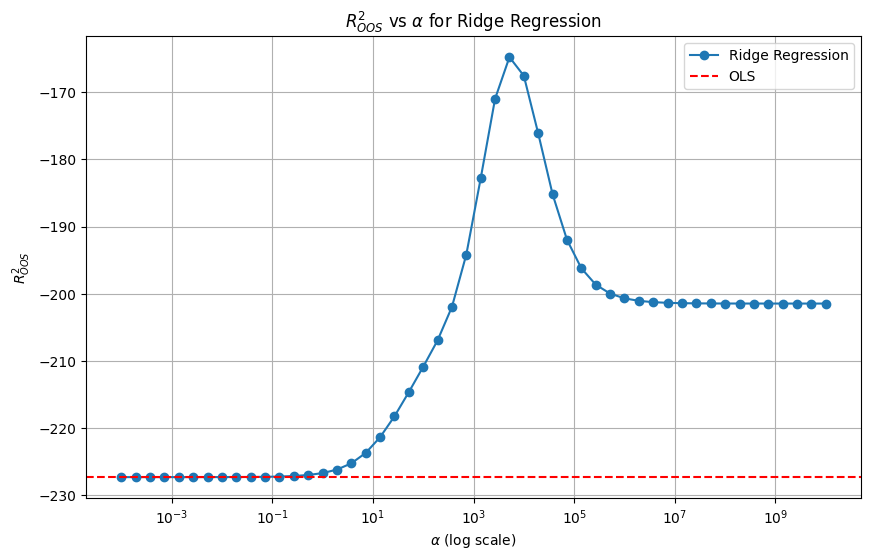

In [39]:
plt.figure(figsize=(10, 6))

plt.semilogx(results_df['alpha'], results_df['R2_OOS'], marker='o', label='Ridge Regression')
plt.axhline(y=R2_OOS_OLS, color='r', linestyle='--', label='OLS')

plt.xlabel(r'$\alpha$ (log scale)')
plt.ylabel(r'$R^2_{OOS}$')
plt.title(r'$R^2_{OOS}$ vs $\alpha$ for Ridge Regression')
plt.legend()
plt.grid(True)
plt.show()

We observe that the out-of-sample $R^2$ improves with L2 regularization. However, even with the optimal alpha parameter, it remains as low as -164.79%, indicating that it is still outperformed by the naive forecast.

## Task #2 bis
We will reload the previously dropped rows to generate more lags.

In [40]:
df = pd.merge(price_df, volume_df, on='Date', suffixes=('_price', '_volume'))

lagged_columns = [col for col in df.columns if col != 'Date']

for col in lagged_columns:
    df[f'{col}_lag'] = df[col].shift(1)
    df[f'{col}_lag2'] = df[col].shift(2)
    df[f'{col}_lag3'] = df[col].shift(3)

df.dropna(inplace=True)
df.head()

,Date,AAPL_price,BA_price,T_price,MGM_price,AMZN_price,IBM_price,TSLA_price,GOOG_price,sp500_price,...,IBM_volume_lag3,TSLA_volume_lag,TSLA_volume_lag2,TSLA_volume_lag3,GOOG_volume_lag,GOOG_volume_lag2,GOOG_volume_lag3,sp500_volume_lag,sp500_volume_lag2,sp500_volume_lag3
3,2012-01-18,61.301430,75.059998,30.33,12.73,189.440002,181.070007,26.809999,315.273285,1308.040039,...,6881000.0,4651600.0,5500400.0,729300.0,3832800.0,4631800.0,3764400.0,4.010490e+09,3.692370e+09,4.019890e+09
4,2012-01-19,61.107143,75.559998,30.42,12.80,194.449997,180.520004,26.760000,318.590851,1314.500000,...,5279200.0,1260200.0,4651600.0,5500400.0,5544000.0,3832800.0,4631800.0,4.096160e+09,4.010490e+09,3.692370e+09
5,2012-01-20,60.042858,75.519997,30.51,12.64,190.929993,188.520004,26.600000,291.900879,1315.380005,...,6003400.0,1246300.0,1260200.0,4651600.0,12657800.0,5544000.0,3832800.0,4.465890e+09,4.096160e+09,4.010490e+09
6,2012-01-23,61.058571,75.510002,30.40,13.14,186.089996,189.979996,26.770000,291.666748,1316.000000,...,4600600.0,662300.0,1246300.0,1260200.0,21231800.0,12657800.0,5544000.0,3.912620e+09,4.465890e+09,4.096160e+09
7,2012-01-24,60.058571,75.360001,30.09,13.16,187.000000,191.929993,27.420000,289.380341,1314.650024,...,8567200.0,594600.0,662300.0,1246300.0,6851300.0,21231800.0,12657800.0,3.770910e+09,3.912620e+09,4.465890e+09


In [41]:
train_size = int(df.shape[0]*0.75)
train = df[:train_size]
test = df[train_size:]

cols_to_scale = train.columns.difference(['Date'])

scaler = MinMaxScaler()
train.loc[:, cols_to_scale] = scaler.fit_transform(train[cols_to_scale])
test.loc[:, cols_to_scale] = scaler.transform(test[cols_to_scale])

data_min = scaler.data_min_
data_max = scaler.data_max_
data_min_dict = dict(zip(cols_to_scale, data_min))
data_max_dict = dict(zip(cols_to_scale, data_max))

In [42]:
# This time, we will include the lags at t-1 and t-2, as well as the S&P 500.
new_features = [col for col in train.columns if '_lag' in col or col == 'sp500_price'] 
new_features

['sp500_price',
 'AAPL_price_lag',
 'AAPL_price_lag2',
 'AAPL_price_lag3',
 'BA_price_lag',
 'BA_price_lag2',
 'BA_price_lag3',
 'T_price_lag',
 'T_price_lag2',
 'T_price_lag3',
 'MGM_price_lag',
 'MGM_price_lag2',
 'MGM_price_lag3',
 'AMZN_price_lag',
 'AMZN_price_lag2',
 'AMZN_price_lag3',
 'IBM_price_lag',
 'IBM_price_lag2',
 'IBM_price_lag3',
 'TSLA_price_lag',
 'TSLA_price_lag2',
 'TSLA_price_lag3',
 'GOOG_price_lag',
 'GOOG_price_lag2',
 'GOOG_price_lag3',
 'sp500_price_lag',
 'sp500_price_lag2',
 'sp500_price_lag3',
 'AAPL_volume_lag',
 'AAPL_volume_lag2',
 'AAPL_volume_lag3',
 'BA_volume_lag',
 'BA_volume_lag2',
 'BA_volume_lag3',
 'T_volume_lag',
 'T_volume_lag2',
 'T_volume_lag3',
 'MGM_volume_lag',
 'MGM_volume_lag2',
 'MGM_volume_lag3',
 'AMZN_volume_lag',
 'AMZN_volume_lag2',
 'AMZN_volume_lag3',
 'IBM_volume_lag',
 'IBM_volume_lag2',
 'IBM_volume_lag3',
 'TSLA_volume_lag',
 'TSLA_volume_lag2',
 'TSLA_volume_lag3',
 'GOOG_volume_lag',
 'GOOG_volume_lag2',
 'GOOG_volume_lag

In [43]:
train_pooled, dummy_cols = prepare_pooled_data(train, new_features, targets)
test_pooled, _ = prepare_pooled_data(test, new_features, targets)
model = train_ridge(train_pooled, new_features, dummy_cols, alpha=best_alpha)
train_pooled = make_predictions(model, train_pooled, new_features, dummy_cols, model_type='Ridge')
test_pooled = make_predictions(model, test_pooled, new_features, dummy_cols, model_type='Ridge')
test_pooled = calculate_returns(test_pooled)

print(R2_OOS(test_pooled['actual_return'], test_pooled['predicted_return']))
print(count_same_sign(test_pooled['actual_return'], test_pooled['predicted_return']))

-167.1426114426224
0.522495361781076


As we can see, the difference in metrics compared to previous models is negligible. It appears that linear models are unable to capture the relationships between lagged prices and current prices.

## Task #3

In [44]:
train_pooled.columns

Index(['Date', 'sp500_price', 'AAPL_price_lag', 'AAPL_price_lag2',
       'AAPL_price_lag3', 'BA_price_lag', 'BA_price_lag2', 'BA_price_lag3',
       'T_price_lag', 'T_price_lag2', 'T_price_lag3', 'MGM_price_lag',
       'MGM_price_lag2', 'MGM_price_lag3', 'AMZN_price_lag', 'AMZN_price_lag2',
       'AMZN_price_lag3', 'IBM_price_lag', 'IBM_price_lag2', 'IBM_price_lag3',
       'TSLA_price_lag', 'TSLA_price_lag2', 'TSLA_price_lag3',
       'GOOG_price_lag', 'GOOG_price_lag2', 'GOOG_price_lag3',
       'sp500_price_lag', 'sp500_price_lag2', 'sp500_price_lag3',
       'AAPL_volume_lag', 'AAPL_volume_lag2', 'AAPL_volume_lag3',
       'BA_volume_lag', 'BA_volume_lag2', 'BA_volume_lag3', 'T_volume_lag',
       'T_volume_lag2', 'T_volume_lag3', 'MGM_volume_lag', 'MGM_volume_lag2',
       'MGM_volume_lag3', 'AMZN_volume_lag', 'AMZN_volume_lag2',
       'AMZN_volume_lag3', 'IBM_volume_lag', 'IBM_volume_lag2',
       'IBM_volume_lag3', 'TSLA_volume_lag', 'TSLA_volume_lag2',
       'TSLA_volume_l

In [45]:
train_pooled, dummy_cols = prepare_pooled_data(train, new_features, targets)
test_pooled, _ = prepare_pooled_data(test, new_features, targets)

In [46]:
X_train = train_pooled[new_features + dummy_cols]
y_train_scaled = train_pooled['y_scaled']

X_test = test_pooled[new_features + dummy_cols]
y_test_scaled = test_pooled['y_scaled']

### Neural Network

In [47]:
model = Sequential()

model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

/Users/marklevin/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [48]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model and save the history for plotting
history = model.fit(X_train, y_train_scaled, epochs=100, batch_size=16, validation_split=0.2, verbose=1, shuffle=False, callbacks=[early_stopping])

# Predict on test data
test_pooled_nn = make_predictions(model, test_pooled.copy(), new_features, dummy_cols, model_type='NN')
test_pooled_nn = calculate_returns(test_pooled_nn)

Epoch 1/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 1s 605us/step - loss: 0.0588 - val_loss: 0.1238
Epoch 2/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 0.0414 - val_loss: 0.1060
Epoch 3/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0360 - val_loss: 0.0954
Epoch 4/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step - loss: 0.0320 - val_loss: 0.0738
Epoch 5/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 0.0285 - val_loss: 0.0597
Epoch 6/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.0256 - val_loss: 0.0476
Epoch 7/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.0238 - val_loss: 0.0348
Epoch 8/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - loss: 0.0209 - val_loss: 0.0253
Epoch 9/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 0.0192 - val_loss: 0.0238
Epoch 10/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0177 - val_loss: 0.0187
Epoch 11/100
647/647 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.0163 - val_loss: 0.0188
Epoch 12/100
647/64

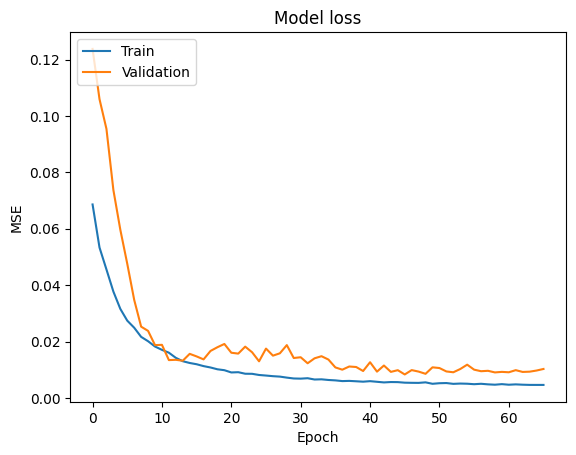

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [50]:
print(R2_OOS(test_pooled_nn['actual_return'], test_pooled_nn['predicted_return']))
print(count_same_sign(test_pooled_nn['actual_return'], test_pooled_nn['predicted_return']))

-72.69934203582793
0.5187847866419295


### Gradient Boosting

In [51]:
# Hyperparameter tuning

def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train_scaled, test_size=0.25, shuffle=False)
    dtrain = lgb.Dataset(train_x, label=train_y)

    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(valid_x)

    rmse = root_mean_squared_error(valid_y, preds)
    return rmse


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-10-28 18:22:27,684] A new study created in memory with name: no-name-29939de8-20f8-4f43-9a35-f59844f30315
[I 2024-10-28 18:22:28,498] Trial 0 finished with value: 0.15074656496900762 and parameters: {'lambda_l1': 0.03834701939075192, 'lambda_l2': 8.86887377615013, 'num_leaves': 81, 'feature_fraction': 0.6287841369375748, 'bagging_fraction': 0.45023588625342864, 'bagging_freq': 5, 'min_child_samples': 15}. Best is trial 0 with value: 0.15074656496900762.
[I 2024-10-28 18:22:30,434] Trial 1 finished with value: 0.1624829520305892 and parameters: {'lambda_l1': 1.1024307554671123e-06, 'lambda_l2': 0.14439893378164642, 'num_leaves': 218, 'feature_fraction': 0.8245308758937824, 'bagging_fraction': 0.5018900503491074, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 0 with value: 0.15074656496900762.
[I 2024-10-28 18:22:31,026] Trial 2 finished with value: 0.15891111280089878 and parameters: {'lambda_l1': 1.4469538749491874e-05, 'lambda_l2': 0.0023598805096651876, 'num_leave

Number of finished trials: 100
Best trial:
  Value: 0.1356780489947097
  Params: 
    lambda_l1: 9.866308341681103
    lambda_l2: 0.005557096905925981
    num_leaves: 114
    feature_fraction: 0.8636874941186803
    bagging_fraction: 0.9014167529257033
    bagging_freq: 6
    min_child_samples: 5


In [52]:
best_params = trial.params

lgb_train = lgb.Dataset(X_train, y_train_scaled)
lgb_test = lgb.Dataset(X_test, y_test_scaled, reference=lgb_train)

gbm = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_test],
    callbacks=[lgb.early_stopping(stopping_rounds=5)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14039
[LightGBM] [Info] Number of data points in the train set: 12936, number of used features: 62
[LightGBM] [Info] Start training from score 0.405407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [53]:
test_pooled_gbm = make_predictions(gbm, test_pooled.copy(), new_features, dummy_cols, model_type='GBM')
test_pooled_gbm = calculate_returns(test_pooled_gbm)

print(R2_OOS(test_pooled_gbm['actual_return'], test_pooled_gbm['predicted_return']))
print(count_same_sign(test_pooled_gbm['actual_return'], test_pooled_gbm['predicted_return']))

-114.18387734897495
0.5278293135435993


In [54]:
# Predictions on the train set for the plot

train_pooled_nn = make_predictions(model, train_pooled.copy(), new_features, dummy_cols, model_type='NN')
train_pooled_gbm = make_predictions(gbm, train_pooled.copy(), new_features, dummy_cols, model_type='GBM')

405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


In [55]:
def plot_nn_gbm_results(train_pooled_nn, test_pooled_nn, train_pooled_gbm, test_pooled_gbm, train_dates, stock_ticker):
    # Combine pooled data for NN and GBM
    combined_nn = pd.concat([train_pooled_nn, test_pooled_nn], ignore_index=True)
    combined_gbm = pd.concat([train_pooled_gbm, test_pooled_gbm], ignore_index=True)
    
    # Filter for the selected stock data
    nn_stock_data = combined_nn[combined_nn['target'] == f'{stock_ticker}_price'].copy()
    gbm_stock_data = combined_gbm[combined_gbm['target'] == f'{stock_ticker}_price'].copy()
    
    # Merge NN and GBM predictions
    merged_data = nn_stock_data[['Date', 'y', 'y_pred']].merge(
        gbm_stock_data[['Date', 'y_pred']],
        on='Date',
        suffixes=('_nn', '_gbm')
    )
    
    merged_data['Date'] = pd.to_datetime(merged_data['Date'])
    
    # Prepare data for plotting
    plot_data = merged_data.melt(
        id_vars='Date',
        value_vars=['y', 'y_pred_nn', 'y_pred_gbm'],
        var_name='Type',
        value_name='Price'
    )
    
    # Map 'Type' values for better labels
    plot_data['Type'] = plot_data['Type'].map({'y': 'Actual', 'y_pred_nn': 'NN Predicted', 'y_pred_gbm': 'GBM Predicted'})
    
    # Indicate training and test sets
    last_train_date = pd.to_datetime(train_dates.iloc[-1])
    plot_data['Set'] = plot_data['Date'].apply(lambda x: 'Training' if x <= last_train_date else 'Test')
    
    # Plot
    fig = px.line(
        plot_data,
        x='Date',
        y='Price',
        color='Type',
        line_dash='Set',
        title=f'Actual vs Predicted Prices of {stock_ticker}'
    )
    
    fig.update_layout(
        xaxis_title='Date',
        yaxis_title='Price',
    )
    
    fig.show()

plot_nn_gbm_results(train_pooled_nn, test_pooled_nn, train_pooled_gbm, test_pooled_gbm, train['Date'], 'AAPL')

### Comment 1: which method performs the best ? Is it in line with Gu et al., (2020). Can we really compare ?
We found that the neural network performed the best, with an $R^2_{OOS}$ of -72.70% and a correct sign prediction rate of 51.88%. Gradient boosting (XGBoost) followed closely, with an $R^2_{OOS}$ of -114.18% and an even slightly higher correct sign prediction rate of 52.78%. Both models outperformed OLS and Ridge, though they still underperformed compared to the naive estimator. In Gu et al. (2020), the neural network and gradient boosting regression trees (GBRT) were also the top models, but their $R^2_{OOS}$ values were positive, indicating that they outperformed the naive estimator. Generally, Gu et al. achieved significantly better performance across all models. However, a direct comparison may not be entirely appropriate, as their study included data from all firms listed on the NYSE, AMEX, and NASDAQ—totaling around 30,000 stocks—whereas our sample only consisted of 8 stocks.
### Comment 2: What about Jiang et al. (2023) paper?
In this paper, the authors approach prediction as a classification task and use McFadden's $R^2$, which differs significantly from the measure we use. Therefore, comparing our results would not be appropriate. However, we could assume that their results are better because image representations themselves could potentially improve predictive performance, and they also allowed the use of more advanced convolutional neural networks compared to the simple architecture we used.


## Optional Task #4: Performance of the AI-driven portfolio
We will use NN predictions, as this model performed the best.

In [56]:
pred_returns = test_pooled_nn.pivot(index='Date', columns='target', values='predicted_return')
actual_returns = test_pooled_nn.pivot(index='Date', columns='target', values='actual_return')

pred_returns.columns = pred_returns.columns.str.replace('_price', '')
actual_returns.columns = actual_returns.columns.str.replace('_price', '')

# Sort by date
pred_returns.sort_index(inplace=True)
actual_returns.sort_index(inplace=True)

In [57]:
display(pred_returns.head())
display(actual_returns.head())

target,AAPL,AMZN,BA,GOOG,IBM,MGM,TSLA,T
Date,,,,,,,,
2018-06-21,0.017455,-0.095509,-0.045895,-0.192808,-0.000959,-0.087845,-0.057194,0.012656
2018-06-22,0.036027,-0.094317,-0.024153,-0.203972,0.014000,-0.081621,-0.028007,0.025998
2018-06-25,-0.006430,-0.145315,-0.047881,-0.220021,0.006013,-0.083608,-0.052106,0.022405
2018-06-26,0.011373,-0.059030,-0.033240,-0.167646,0.020057,-0.076166,0.018889,0.017836
2018-06-27,-0.010618,-0.108454,-0.030392,-0.209098,0.021316,-0.076008,-0.057861,0.025573


target,AAPL,AMZN,BA,GOOG,IBM,MGM,TSLA,T
Date,,,,,,,,
2018-06-21,-0.005576,-0.019981,-0.014678,-0.010412,-0.009675,-0.007531,-0.041009,-0.012500
2018-06-22,-0.002912,-0.017060,0.003702,-0.001883,0.000212,-0.007918,-0.040350,0.002848
2018-06-25,-0.014871,-0.039039,-0.022749,-0.026543,-0.017625,-0.026605,-0.001878,0.000631
2018-06-26,0.012406,0.007946,0.000302,-0.005645,0.002090,-0.003758,0.027284,-0.002838
2018-06-27,-0.001464,-0.026617,-0.004467,-0.012946,-0.011504,-0.027092,0.007386,0.000949


In [58]:
def create_ai_portfolio(pred_returns, actual_returns, trading_fee_rate, initial_investment=100, top_n=4):
    """
    Simulate an AI-based portfolio by selecting and investing in stocks based
    on predicted returns and updating the portfolio based on actual returns.
    """
    ai_portfolio = pd.DataFrame(index=pred_returns.index, columns=['Portfolio Value'], dtype='float')
    ai_portfolio.iloc[0] = float(initial_investment)
    ai_positions = pd.DataFrame(0, index=pred_returns.index, columns=pred_returns.columns, dtype='float')

    for i in range(len(pred_returns)):
        # Previous day's portfolio value
        previous_value = initial_investment if i == 0 else ai_portfolio.iloc[i-1].values[0]
        
        # Select top N stocks based on predicted returns
        top_stocks = pred_returns.iloc[i].nlargest(top_n).index.tolist()
        
        # Calculate the total amount to be invested
        total_allocation = previous_value * (1 - trading_fee_rate)
        
        # Allocate equally to top stocks
        ai_positions.loc[pred_returns.index[i], top_stocks] = total_allocation / top_n
        
        # Calculate today's portfolio return based on actual returns
        daily_return = (actual_returns.iloc[i] * ai_positions.iloc[i]).sum() / previous_value
        
        # Update portfolio value
        ai_portfolio.iloc[i] = total_allocation * (1 + daily_return)

    return ai_portfolio, ai_positions

In [59]:
def run_simulations(actual_returns, trading_fee_rate, initial_investment=100, num_simulations=1000):
    """
    Simulate portfolio growth over time with randomly generated weights.
    """
    simulations = []

    for _ in range(num_simulations):
        weights = np.random.dirichlet(np.ones(actual_returns.shape[1]))
        portfolio = ((actual_returns * weights).sum(axis=1) + 1).cumprod() * initial_investment * (1 - trading_fee_rate)
        simulations.append(portfolio)

    simulations_df = pd.DataFrame(simulations).T
    return simulations_df

In [60]:
def equal_weights_portfolio(actual_returns, trading_fee_rate, initial_investment=100):
    weights = [0.25] * 8
    portfolio = ((actual_returns * weights).sum(axis=1) + 1).cumprod() * initial_investment * (1 - trading_fee_rate)
    return portfolio

In [61]:
ai_portfolio, _ = create_ai_portfolio(pred_returns, actual_returns, 0.0)
print(f'We would have ${ai_portfolio.iloc[-1, 0]:.2f} at the end of the testing period.')

We would have $100.27 at the end of the testing period.


In [62]:
simulations_df = run_simulations(actual_returns, 0.0)
ew_portfolio = equal_weights_portfolio(actual_returns, 0)

In [63]:
def plot_portfolio_performance(ai_portfolio, ew_portfolio, simulations_df, title):
    """
    Plot AI portfolio performance against random similated portfolios with confidence intervals.
    """
    simulations_df.index = pd.to_datetime(simulations_df.index)
    ai_portfolio.index = pd.to_datetime(ai_portfolio.index)
    ew_portfolio.index = pd.to_datetime(ew_portfolio.index)

    plt.figure(figsize=(12, 6))
    
    # Calculate percentiles for simulations
    sim_median = simulations_df.median(axis=1)
    sim_25 = simulations_df.quantile(0.25, axis=1)
    sim_75 = simulations_df.quantile(0.75, axis=1)
    sim_5 = simulations_df.quantile(0.05, axis=1)
    sim_95 = simulations_df.quantile(0.95, axis=1)
    
    # Plot simulation ranges
    plt.fill_between(simulations_df.index, sim_5, sim_95, 
                     color='lightgray', alpha=0.5, label='90% CI for Simulated Portfolios')
    plt.fill_between(simulations_df.index, sim_25, sim_75,
                     color='gray', alpha=0.5, label='50% CI for Simulated Portfolios')
    
    # Plot median simulation line
    plt.plot(simulations_df.index, sim_median, 
             color='blue', linestyle='--', label='Simulated Portfolios Median')
    
    # Plot AI portfolio performance
    plt.plot(ai_portfolio.index, ai_portfolio['Portfolio Value'],
             color='red', linewidth=2, label='AI Portfolio')
    
    plt.plot(ew_portfolio.index, ew_portfolio.values,
             color='purple', linewidth=2, label='Equal Weights Portfolio')
    
    plt.title(title, 
             fontsize=14, pad=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Portfolio Value', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper left', frameon=True)
    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=3))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

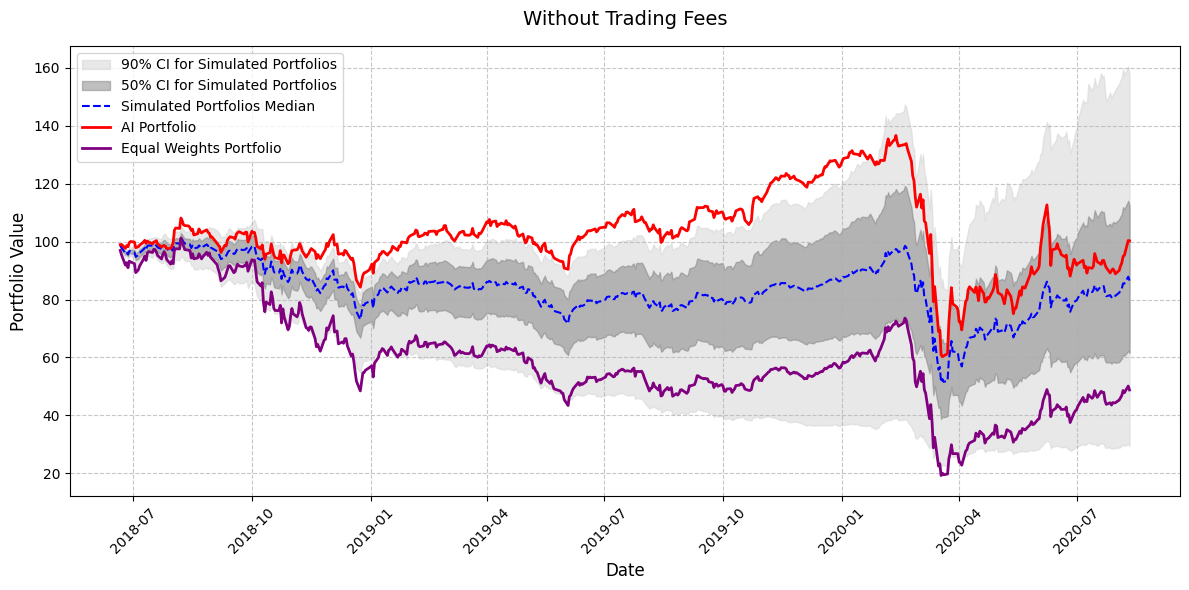

In [64]:
plot_portfolio_performance(ai_portfolio, ew_portfolio, simulations_df, title='Without Trading Fees')

In [65]:
ai_portfolio_fees, _ = create_ai_portfolio(pred_returns, actual_returns, 0.03)
simulations_df_fees = run_simulations(actual_returns, 0.03)
ew_portfolio_fees = equal_weights_portfolio(actual_returns, 0.03)

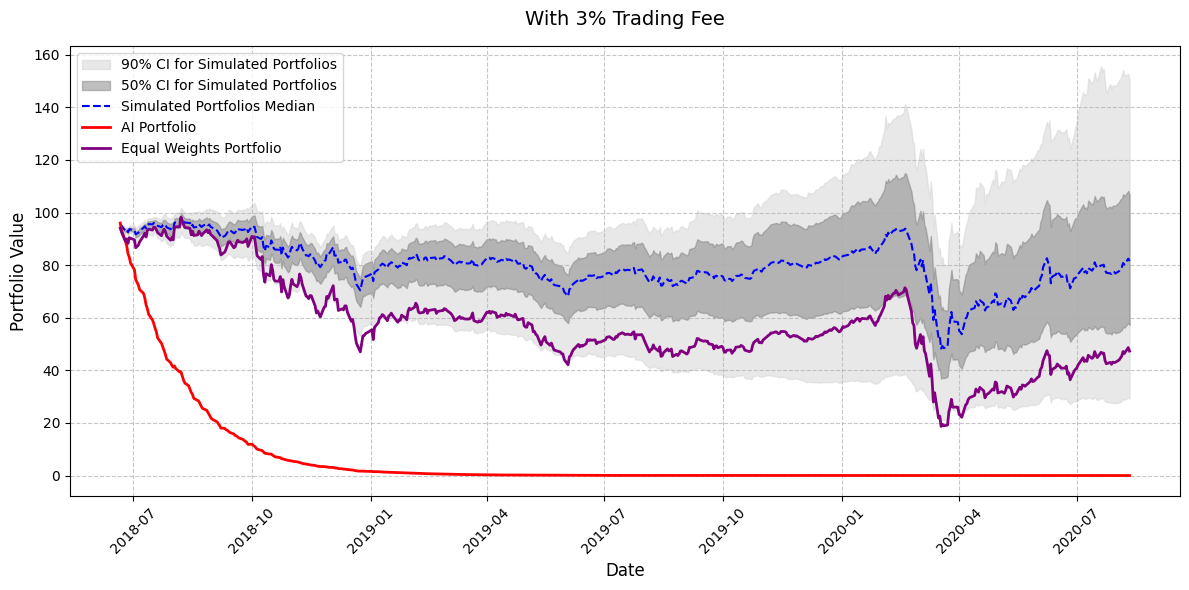

In [66]:
plot_portfolio_performance(ai_portfolio_fees, ew_portfolio_fees, simulations_df_fees, title='With 3% Trading Fee')